In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Data 

In [4]:
data = pd.read_csv('Global_Superstore2.csv', encoding = "latin-1")
data.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,32298,CA-2012-124891,31-07-2012,31-07-2012,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,...,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical
1,26341,IN-2013-77878,05-02-2013,07-02-2013,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,...,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical
2,25330,IN-2013-71249,17-10-2013,18-10-2013,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,...,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium


In [5]:
# Removing irrelevant columns
df = data.drop(['Row ID', 'Order ID', 'Ship Date', 'Customer ID', 'Customer Name',
              'Postal Code', 'Product ID', 'Product Name'], axis = 1)
# df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Order Date      51290 non-null  object 
 1   Ship Mode       51290 non-null  object 
 2   Segment         51290 non-null  object 
 3   City            51290 non-null  object 
 4   State           51290 non-null  object 
 5   Country         51290 non-null  object 
 6   Market          51290 non-null  object 
 7   Region          51290 non-null  object 
 8   Category        51290 non-null  object 
 9   Sub-Category    51290 non-null  object 
 10  Sales           51290 non-null  float64
 11  Quantity        51290 non-null  int64  
 12  Discount        51290 non-null  float64
 13  Profit          51290 non-null  float64
 14  Shipping Cost   51290 non-null  float64
 15  Order Priority  51290 non-null  object 
dtypes: float64(4), int64(1), object(11)
memory usage: 6.3+ MB


In [6]:
# Number of categories in each categorical variable

for i in df:
    if df[i].dtype == ('object' or 'category'):
        print(i, len(df[i].unique()))

Order Date 1430
Ship Mode 4
Segment 3
City 3636
State 1094
Country 147
Market 7
Region 13
Category 3
Sub-Category 17
Order Priority 4


### Monthly sales for all categories 

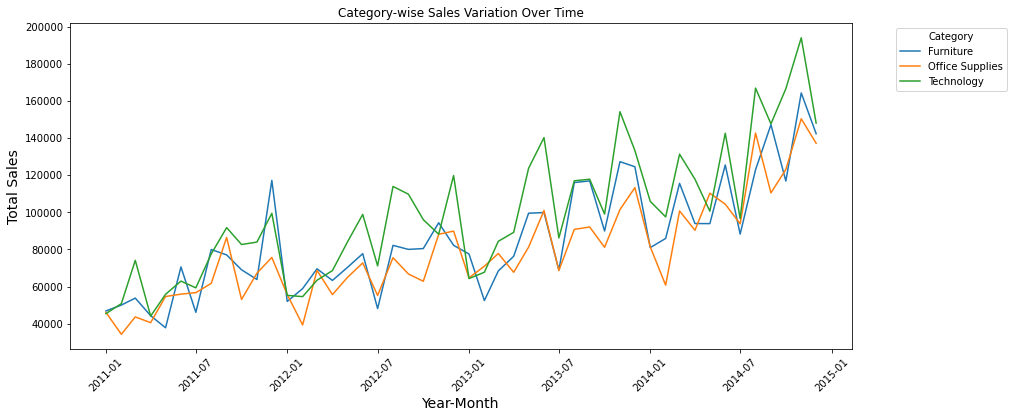

In [7]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['YearMonth'] = df['Order Date'].dt.to_period('M')  # setting to monthly steps

# Convert 'YearMonth' to timestamp
df['YearMonth'] = df['YearMonth'].dt.to_timestamp()

category_sales = df.groupby(['YearMonth', 'Category'])['Sales'].sum().reset_index()
sub_category_sales = df.groupby(['YearMonth', 'Category', 'Sub-Category'])['Sales'].sum().reset_index()

plt.figure(figsize = (14, 6))
sns.lineplot(x = 'YearMonth', y = 'Sales', hue = 'Category', data = category_sales, markers = True)
plt.title('Category-wise Sales Variation Over Time')
plt.xlabel('Year-Month', fontsize = 14)
plt.ylabel('Total Sales', fontsize = 14)
plt.xticks(rotation = 45)
plt.legend(title='Category', bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.show()

### Correlation among numerical features 

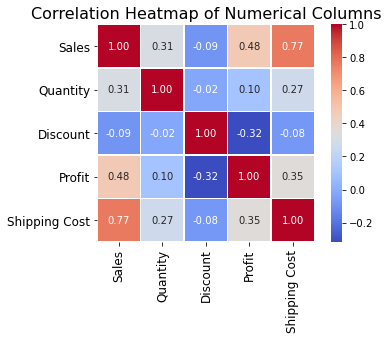

In [11]:
numerical_feat = ['Sales', 'Quantity', 'Discount', 'Profit', 'Shipping Cost']
numerical_df = df[numerical_feat]

correlation_matrix = numerical_df.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True)

plt.title('Correlation Heatmap of Numerical Columns', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


ENCODING CATEGORICAL VARIABLES WITH LOWER CARDINALITY

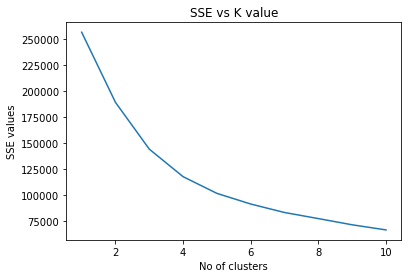

In [12]:
# Create a new DataFrame with selected features
customer_data = df[numerical_feat]

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data)

# WCSS method for finding the optimal k
sse = []
for k in range(1, 11):
    k_means = KMeans(n_clusters = k, n_init = 10)
    k_means.fit(scaled_data)  # Use fit instead of fit_predict
    sse.append(k_means.inertia_)
    
    
plt.plot(range(1,11),sse)
plt.xlabel("No of clusters")
plt.ylabel("SSE values")
plt.title("SSE vs K value")
plt.show()

In [13]:
print(sse)

[256450.0000000005, 189076.9449537104, 144172.98670558105, 117711.53530104263, 101685.30227506017, 91451.68382735213, 83324.76376151232, 77468.67708215803, 71511.76171315326, 66600.29574251971]


In [14]:
# Choose the number of clusters (K)
k = 4

# Apply K-means algorithm
kmeans = KMeans(n_clusters = k, random_state = 42)
df['Cluster'] = kmeans.fit_predict(scaled_data)

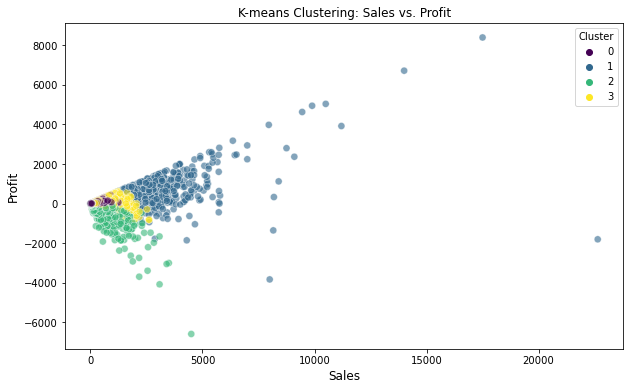

In [15]:
# Scatter plot for 'Sales' and 'Profit' colored by clusters
plt.figure(figsize = (10, 6))
sns.scatterplot(x='Sales', y='Profit', hue='Cluster', s = 50, data=df, palette='viridis', alpha=0.6)
plt.title('K-means Clustering: Sales vs. Profit')
plt.xlabel('Sales', fontsize = 12)
plt.ylabel('Profit', fontsize = 12)
plt.show()

## Creating time series cross validation splits for each cluster  

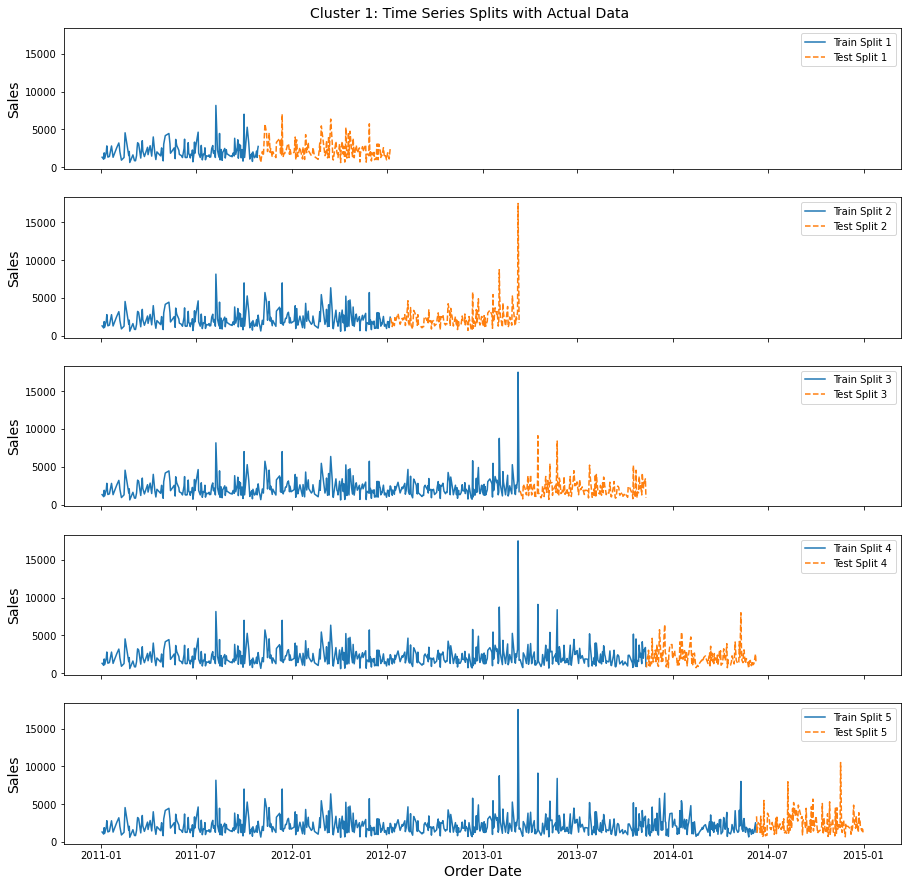

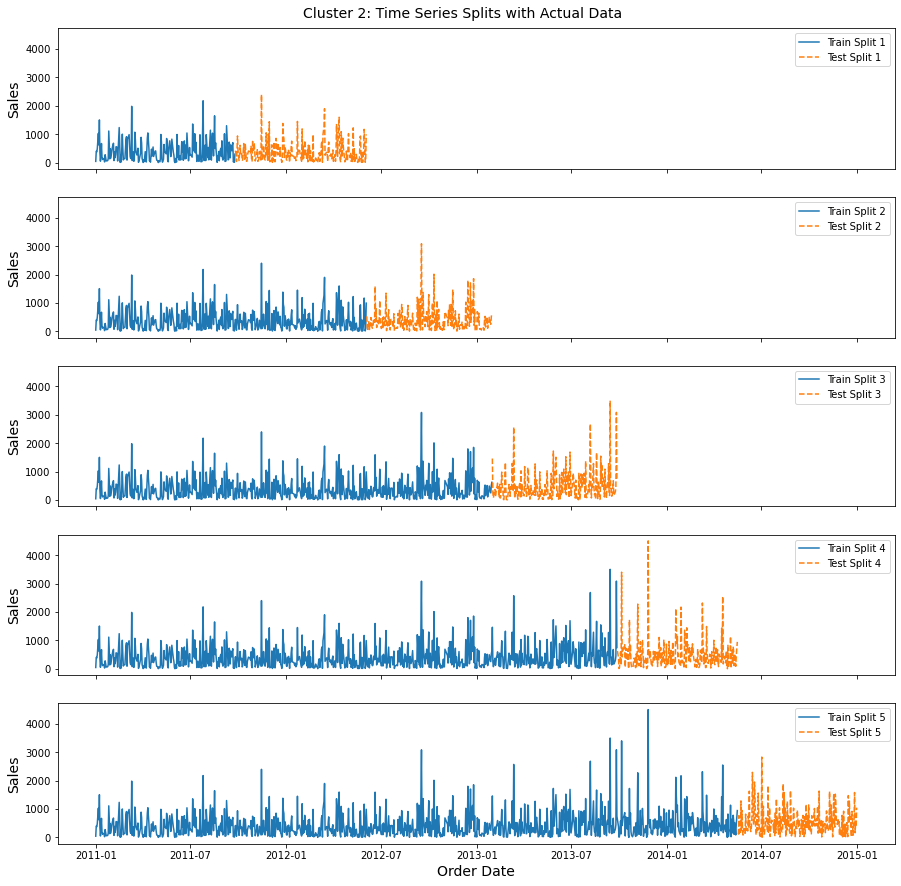

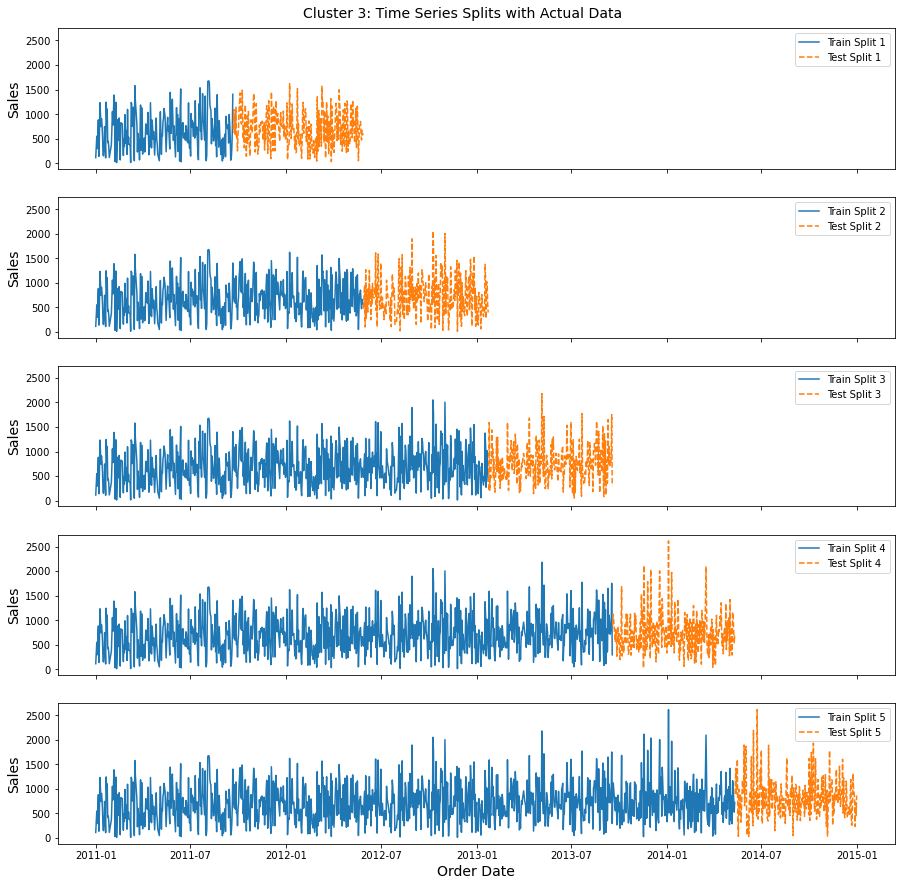

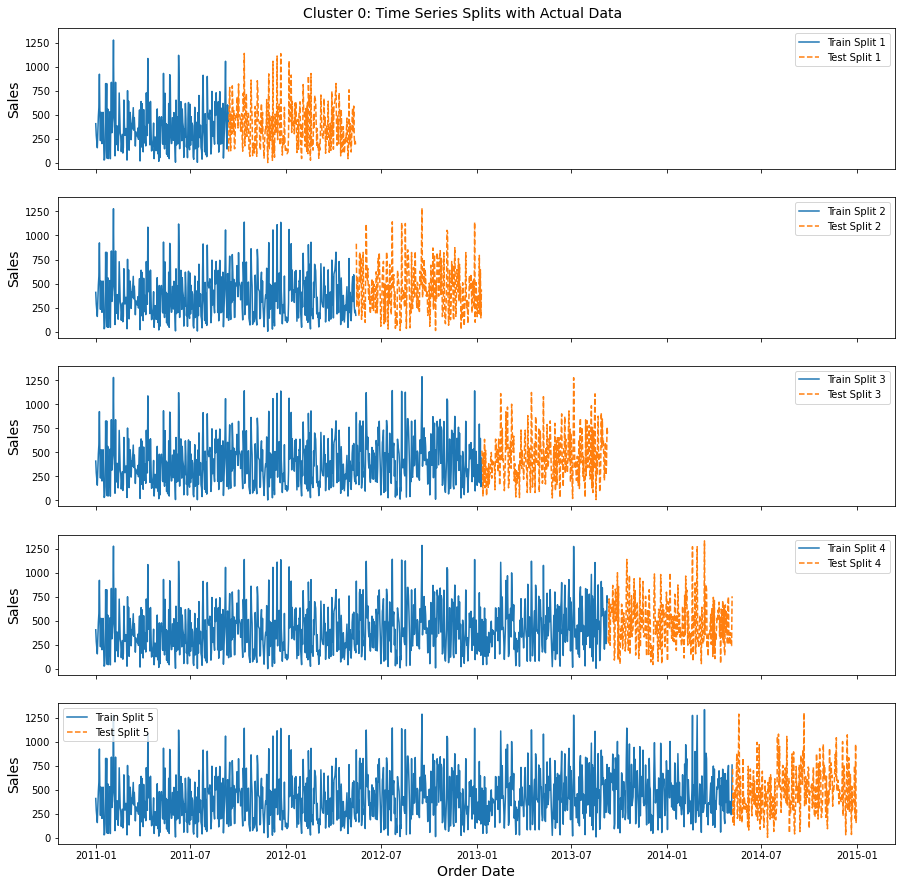

In [17]:
cluster_data = {}
cluster_models = {}

categorical_features = ["Ship Mode", "Segment", "Market", "Category", "Order Priority"]

for cluster_label in df['Cluster'].unique():
    cluster_data[cluster_label] = df[df['Cluster'] == cluster_label].copy()

    label_encoder = LabelEncoder()
    for feature in categorical_features:
        cluster_data[cluster_label][f'{feature}_Encoded'] = label_encoder.fit_transform(
            cluster_data[cluster_label][feature])

    numerical_features = ["Sales", "Quantity", "Discount", "Profit", "Shipping Cost"]
    encoded_features = [f'{feature}_Encoded' for feature in categorical_features]
    selected_features = numerical_features + encoded_features

    # Include 'Order Date' in selected features
    selected_features += ['Order Date']
    
    cluster_data[cluster_label] = cluster_data[cluster_label].groupby('Order Date').first().reset_index()
    
    X = cluster_data[cluster_label][selected_features[1:]]
    y = cluster_data[cluster_label]['Sales']

    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits = 5)

    fig, axes = plt.subplots(nrows = 5, ncols = 1, figsize = (15, 15), sharex = True, sharey = True)
    fig.suptitle(f'Cluster {cluster_label}: Time Series Splits with Actual Data', y = 0.9, fontsize = 14)

    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        ax = axes[i]

        ax.plot(
            cluster_data[cluster_label]['Order Date'].iloc[train_index],
            y.iloc[train_index],
            label = f'Train Split {i + 1}'
        )

        ax.plot(
            cluster_data[cluster_label]['Order Date'].iloc[test_index],
            y.iloc[test_index],
            label = f'Test Split {i + 1}',
            linestyle = 'dashed'
        )

        ax.set_ylabel('Sales', fontsize = 14)
        ax.legend()

    plt.xlabel('Order Date', fontsize = 14)
    plt.show()

In [18]:
warnings.filterwarnings("ignore")

## Predicting `Sales` for each cluster (customer segment) using XG Boost regression 

R^2 value for Cluster 1, Split 1: 0.309
MAE: 638.938
MSE: 976044.94


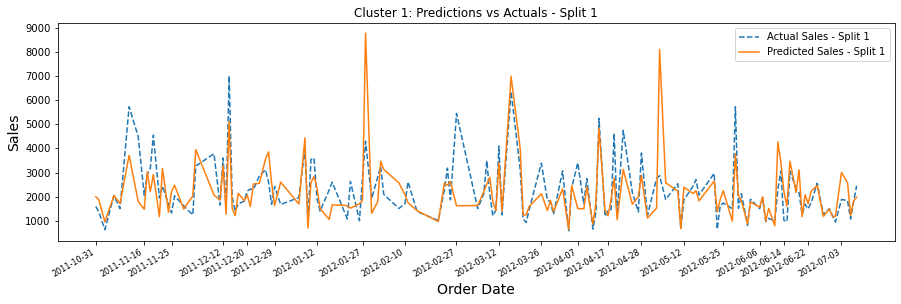

R^2 value for Cluster 1, Split 2: 0.491
MAE: 586.778
MSE: 1455921.16


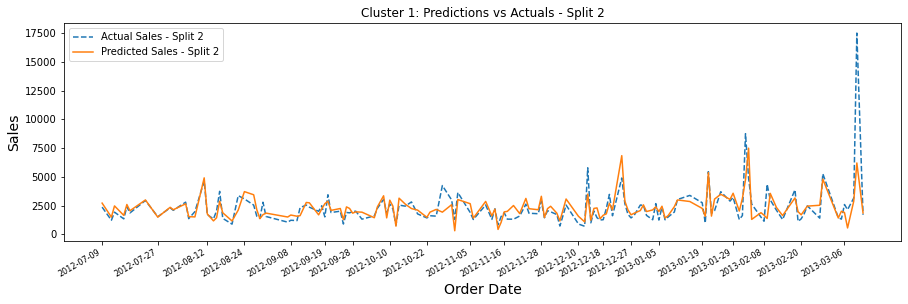

R^2 value for Cluster 1, Split 3: 0.648
MAE: 494.693
MSE: 575119.258


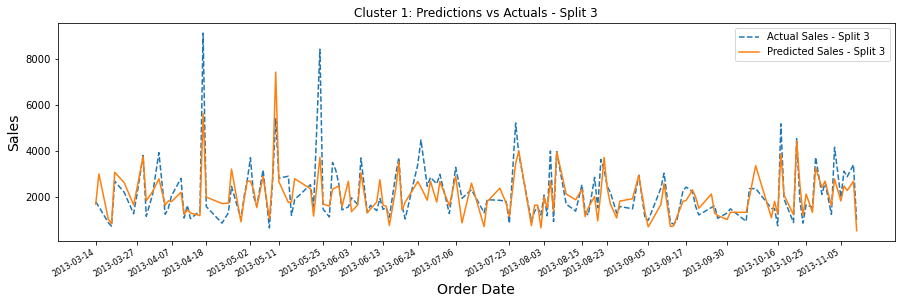

R^2 value for Cluster 1, Split 4: 0.635
MAE: 493.564
MSE: 491497.972


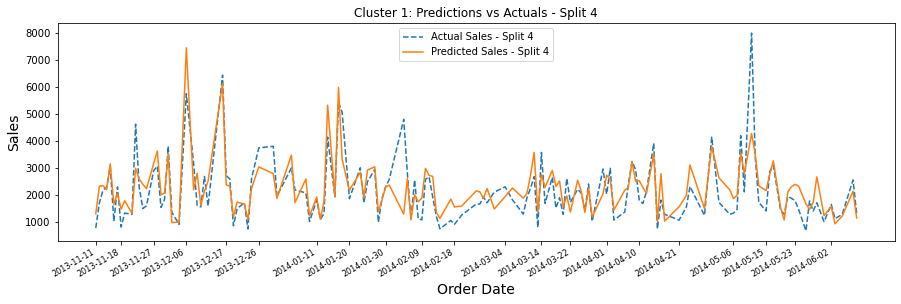

R^2 value for Cluster 1, Split 5: 0.675
MAE: 558.254
MSE: 670460.118


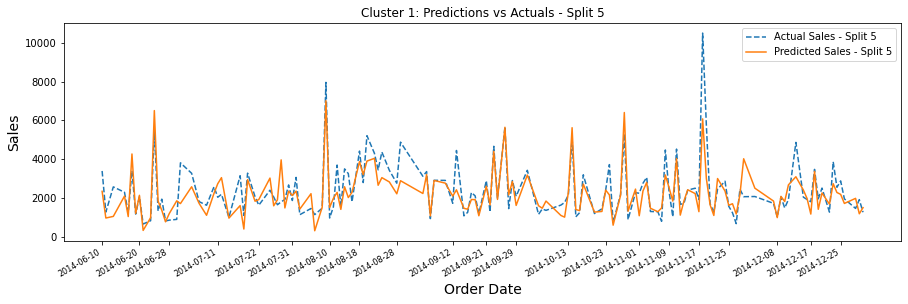

R^2 value for Cluster 2, Split 1: 0.777
MAE: 119.645
MSE: 32384.83


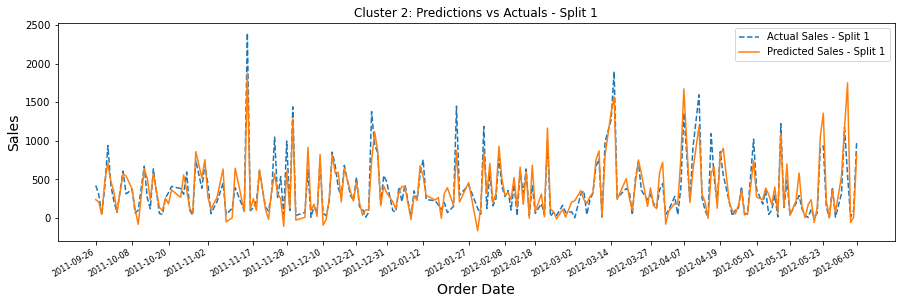

R^2 value for Cluster 2, Split 2: 0.819
MAE: 112.057
MSE: 31707.565


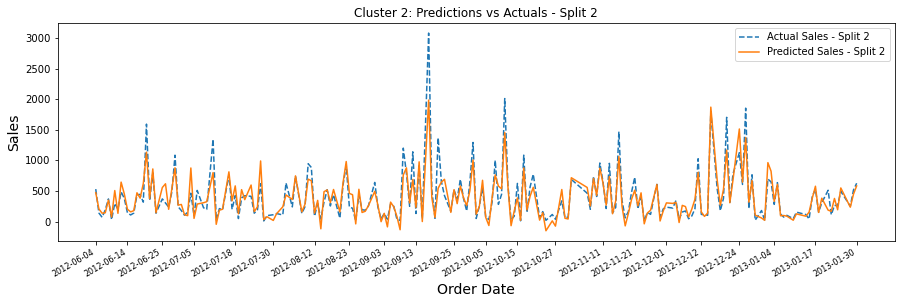

R^2 value for Cluster 2, Split 3: 0.762
MAE: 160.281
MSE: 65477.887


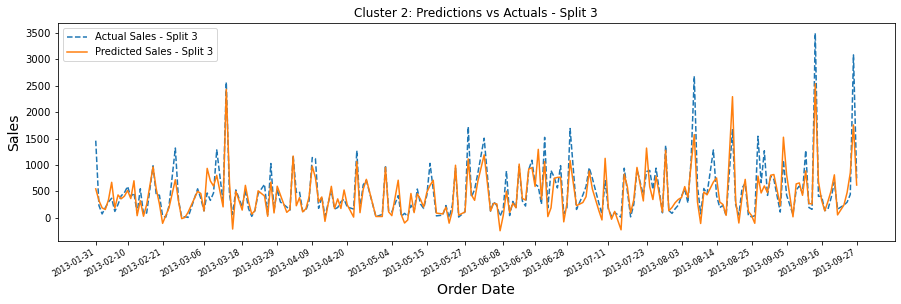

R^2 value for Cluster 2, Split 4: 0.783
MAE: 151.346
MSE: 65548.452


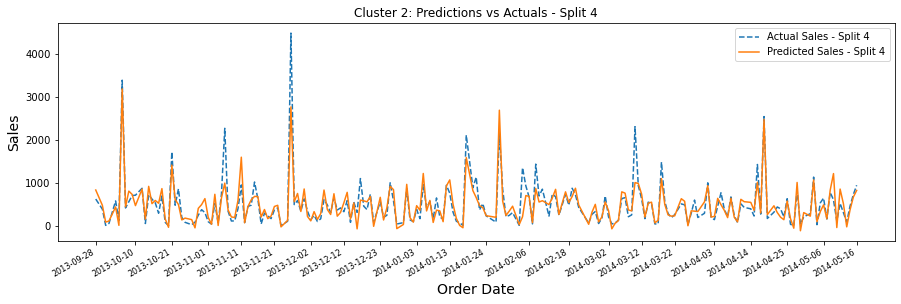

R^2 value for Cluster 2, Split 5: 0.806
MAE: 143.49
MSE: 43699.553


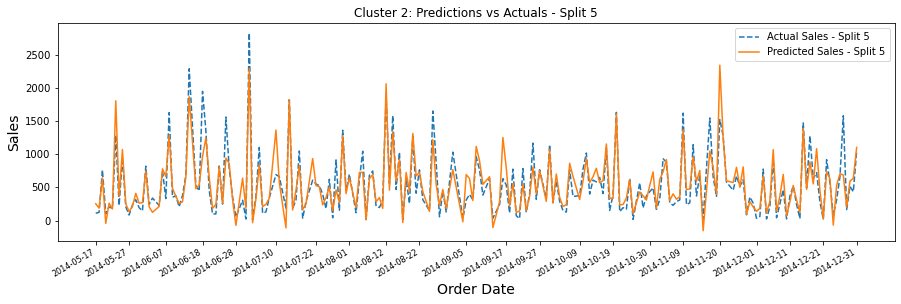

R^2 value for Cluster 3, Split 1: 0.579
MAE: 184.309
MSE: 55480.2


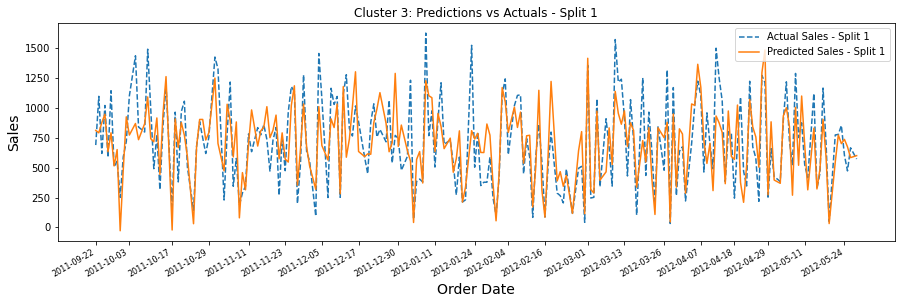

R^2 value for Cluster 3, Split 2: 0.606
MAE: 195.602
MSE: 65212.052


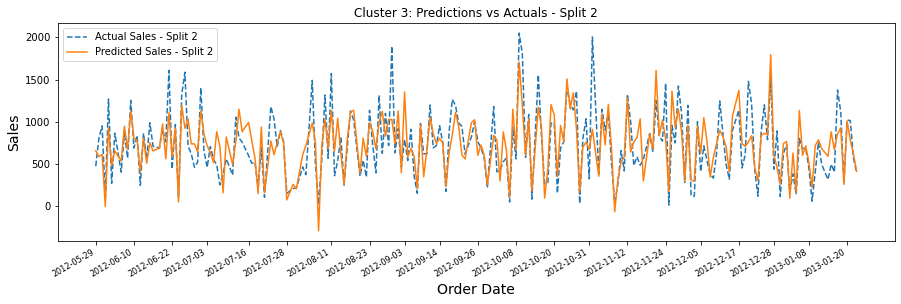

R^2 value for Cluster 3, Split 3: 0.499
MAE: 190.369
MSE: 71836.191


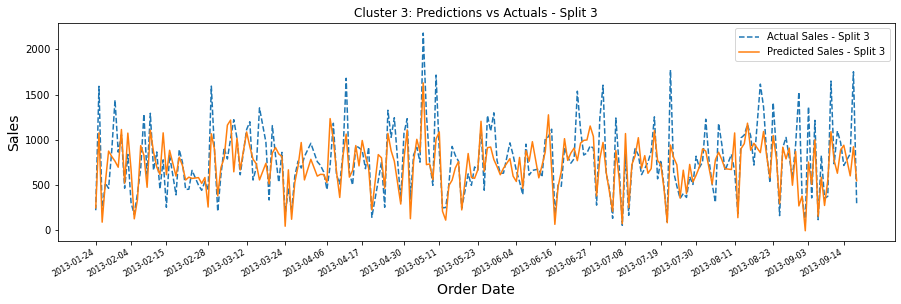

R^2 value for Cluster 3, Split 4: 0.698
MAE: 171.163
MSE: 49306.568


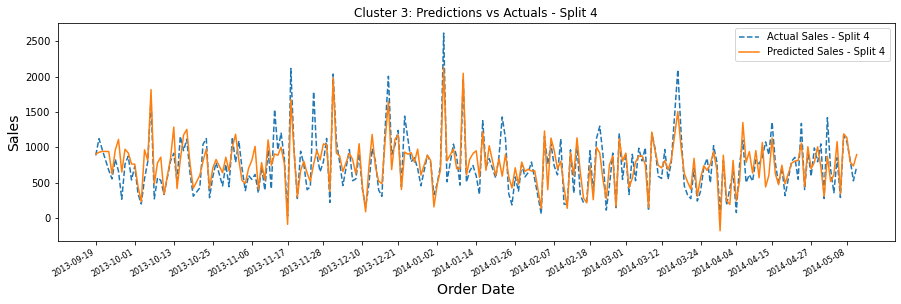

R^2 value for Cluster 3, Split 5: 0.591
MAE: 193.919
MSE: 68042.414


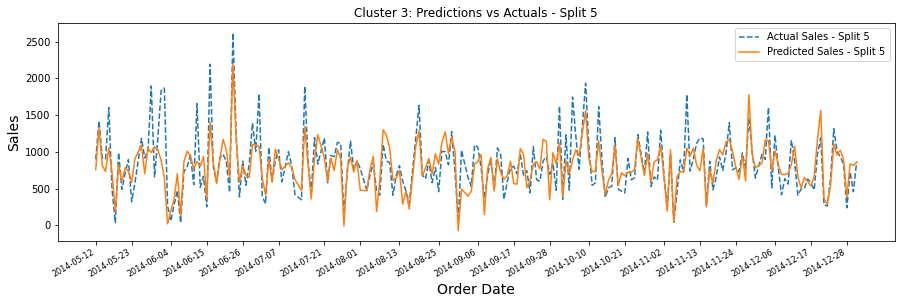

R^2 value for Cluster 0, Split 1: 0.632
MAE: 110.372
MSE: 21315.377


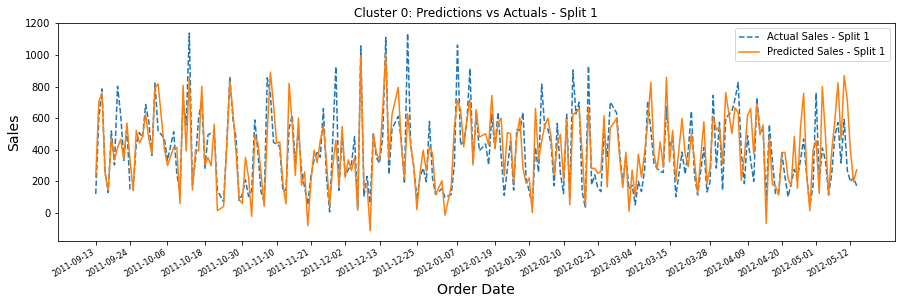

R^2 value for Cluster 0, Split 2: 0.681
MAE: 109.938
MSE: 21537.149


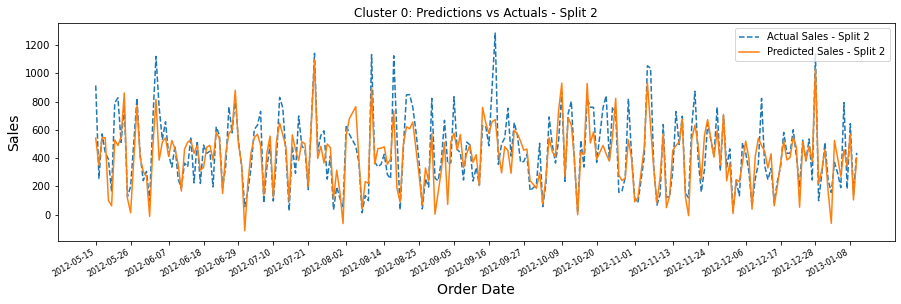

R^2 value for Cluster 0, Split 3: 0.687
MAE: 97.576
MSE: 20049.931


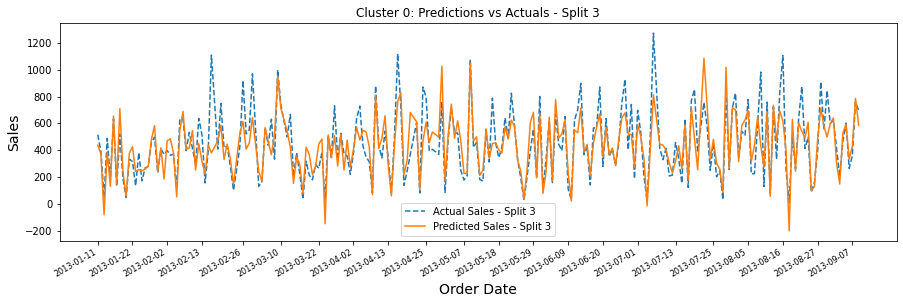

R^2 value for Cluster 0, Split 4: 0.71
MAE: 108.933
MSE: 18844.907


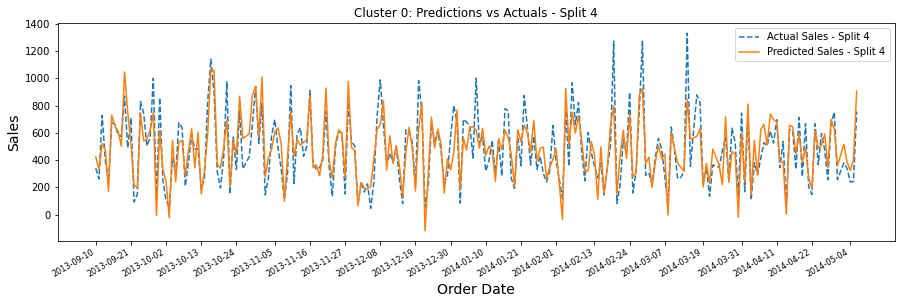

R^2 value for Cluster 0, Split 5: 0.695
MAE: 103.608
MSE: 19230.174


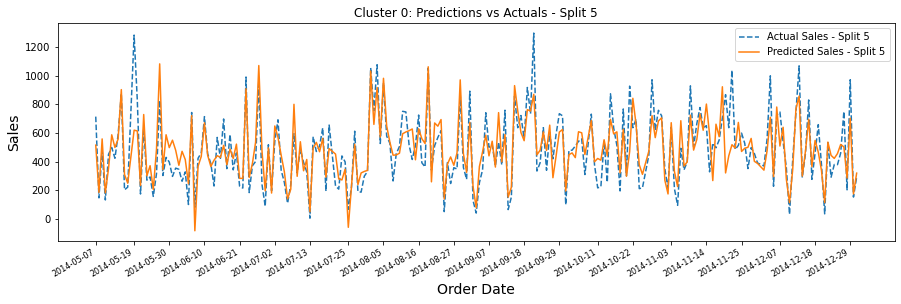

In [19]:
cluster_data = {}
cluster_models = {}

categorical_features = ["Ship Mode", "Segment", "Market", "Category", "Order Priority"]

for cluster_label in df['Cluster'].unique():
    cluster_data[cluster_label] = df[df['Cluster'] == cluster_label].copy()

    label_encoder = LabelEncoder()
    for feature in categorical_features:
        cluster_data[cluster_label][f'{feature}_Encoded'] = label_encoder.fit_transform(
            cluster_data[cluster_label][feature]
        )

    numerical_features = ["Sales", "Quantity", "Discount", "Profit", "Shipping Cost"]
    encoded_features = [f'{feature}_Encoded' for feature in categorical_features]
    selected_features = numerical_features + encoded_features

    # Include 'Order Date' in selected features
    selected_features += ['Order Date']

    cluster_data[cluster_label] = cluster_data[cluster_label][selected_features]
    cluster_data[cluster_label] = cluster_data[cluster_label].groupby('Order Date').first().reset_index()

    X = cluster_data[cluster_label][selected_features[1:]]
    y = cluster_data[cluster_label]['Sales']

    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits = 5)

    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Extract relevant information from 'Order Date'
        X_train['Order Date'] = pd.to_datetime(X_train['Order Date'])
        X_train['Year'] = X_train['Order Date'].dt.year
        X_train['Month'] = X_train['Order Date'].dt.month
        X_train['Day'] = X_train['Order Date'].dt.day
        X_train['DayOfWeek'] = X_train['Order Date'].dt.dayofweek

        X_test['Order Date'] = pd.to_datetime(X_test['Order Date'])
        X_test['Year'] = X_test['Order Date'].dt.year
        X_test['Month'] = X_test['Order Date'].dt.month
        X_test['Day'] = X_test['Order Date'].dt.day
        X_test['DayOfWeek'] = X_test['Order Date'].dt.dayofweek

        # Drop the original 'Order Date' column
        X_train = X_train.drop(columns=['Order Date'])
        X_test = X_test.drop(columns=['Order Date'])

        # Convert categorical columns to dtype 'category'
        cat_cols = X_train.select_dtypes(include = ['object']).columns
        for col in cat_cols:
            X_train[col] = X_train[col].astype('category')
            X_test[col] = X_test[col].astype('category')

        # Initialize and train XGBoost model
        model = XGBRegressor(n_estimators = 1000, max_depth = 1)
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)

        # Evaluate the model (you can use other metrics as needed)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        print(f'R^2 value for Cluster {cluster_label}, Split {i + 1}: {round(r2, 3)}')
        print(f'MAE: {round(mae, 3)}')
        print(f'MSE: {round(mse, 3)}')

        # Plot the predictions against actual values
        plt.figure(figsize = (15, 4))

        # Sort the DataFrame by 'Order Date'
        sorted_indices = X.iloc[test_index]['Order Date'].argsort()
        sorted_dates = X.iloc[test_index]['Order Date'].iloc[sorted_indices]
        sorted_y_test = y_test.iloc[sorted_indices]
        sorted_y_pred = pd.Series(y_pred, index = sorted_dates)

        # Choose a subset of dates for plotting to avoid clutter
        subset_size = min(20, len(sorted_dates)) 
        step = len(sorted_dates) // subset_size
        subset_dates = sorted_dates.iloc[::step]

        plt.plot(sorted_dates, sorted_y_test, label=f'Actual Sales - Split {i + 1}', linestyle='dashed')
        plt.plot(sorted_dates, sorted_y_pred, label=f'Predicted Sales - Split {i + 1}')
        plt.xticks(subset_dates, rotation = 30, ha = 'right') 
        plt.title(f'Cluster {cluster_label}: Predictions vs Actuals - Split {i + 1}')
        plt.xlabel('Order Date', fontsize = 14)
        plt.ylabel('Sales', fontsize = 14)
        plt.xticks(fontsize = 8)
        plt.legend()
        plt.show()

### The task now is to perform hyperparameter tuning for `each cluster (segment) separately` and squeeze out best performance over the cross validation splits 

In [21]:
# Using Grid Search CV for hyperparameter tuning within each cluster 


In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Sales', y='Quantity', hue='Cluster', data=df, palette='viridis')
plt.title('K-means Clustering: Sales vs. Quantity')
plt.xlabel('Sales')
plt.ylabel('Quantity')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Profit', y='Quantity', hue='Cluster', data=df, palette='viridis')
plt.title('K-means Clustering: Profit vs. Quantity')
plt.xlabel('Profit')
plt.ylabel('Quantity')
plt.show()

In [ ]:
sampled_df = df.sample(frac=0.2)  # Adjust the fraction as needed
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Sales', y='Profit', hue='Cluster', data=sampled_df, palette='viridis')

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Sales', y='Profit', hue='Cluster', data=df, palette='viridis', s=50)  # Adjust 's' for marker size


In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['Sales'], df['Profit'], df['Quantity'], c=df['Cluster'], cmap='viridis')
ax.set_xlabel('Sales')
ax.set_ylabel('Profit')
ax.set_zlabel('Quantity', labelpad=25)  # Adjust labelpad to move the label away from the data points

plt.show()

In [ ]:
c1 = df[df['Cluster'] == 0]
c2 = df[df['Cluster'] == 1]
c3 = df[df['Cluster'] == 2]
c4 = df[df['Cluster'] == 3]

In [ ]:
print(c1.shape,c2.shape,c3.shape,c4.shape)

In [ ]:
cluster_summary = df.groupby('Cluster').mean()
print(cluster_summary)


In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Cluster', y='Sales', data=sampled_df)
plt.title('Sales Distribution Across Clusters')


In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Cluster', y='Profit', data=sampled_df)
plt.title('Sales Distribution Across Clusters')

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Cluster', y='Quantity', data=sampled_df)
plt.title('Sales Distribution Across Clusters')

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Cluster', y='Discount', data=sampled_df)
plt.title('Sales Distribution Across Clusters')

In [ ]:
###Now decision trees
df['Cluster'].unique()

In [ ]:
features1 = ['Order Date', 'Ship Mode', 'Segment', 'City', 'State', 'Country', 'Market', 'Region', 'Category', 'Sub-Category', 'Sales', 'Quantity', 'Discount', 'Profit', 'Shipping Cost', 'Order Priority']
X = df[features1]
